In [1]:
from spin_fermi_model import * 

plt.rcParams["font.size"] = 16

In [58]:
states5 = csv_to_states_from_filename('states5_10_spin.csv')
scores = SpinFermi.get_scores(states5)
scores -= scores[0]
e_num = 5

In [59]:
def calc_level_density(states: list[State]):
    """実際のエネルギー準位密度を計算"""
    dct = {}
    for state in states:
        if dct.get(state.score):
            dct[state.score] += 1
        else:
            dct[state.score] = 1
    scores = np.fromiter(dct.keys(), dtype=int)
    scores = scores - scores[0]  # 基底状態のエネルギー準位を0[ε]にする
    level_density = np.fromiter(dct.values(), dtype=int) # ヒストグラムの幅は１として考えればよいので、密度ではあるが何も割る必要がない
    return scores, level_density

# 正規方程式を解く
def solve_normal_equation(xs: NDArray, ys: NDArray):
    """
    Args:
        xs (NDArray[float])
        ys (NDArray[float])
    
    Returns:
        intercept (float): 切片
        slope (float): 傾き
    """
    x_ave = xs.mean()
    y_ave = ys.mean()
    cov = np.sum((xs - x_ave) * (ys - y_ave))
    var = np.sum((xs - x_ave)**2)
    slope = cov / var
    intercept = y_ave - x_ave * slope
    return intercept, slope

def calc_approx_level_density(states: list[State], rho_0: float, eps_0: float) -> NDArray[np.float64]:
    """近似したエネルギー準位密度を計算"""
    # 昇順にソート
    scores = np.sort(np.array(list({state.score for state in states})))
    scores = scores - scores[0]  # 基底状態のエネルギー準位を0[ε]にする
    return rho_0 * np.exp(scores/eps_0)

In [60]:
all_scores = np.array(sorted([state.score for state in states5]))
all_scores -= all_scores[0]

In [61]:
all_scores

array([ 0,  0,  1, ..., 10, 10, 10], dtype=int64)

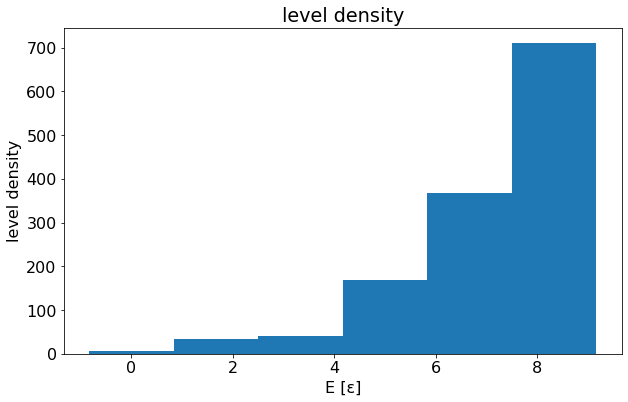

In [92]:
bin_num = 6
hist, bins = np.histogram(all_scores, bins=bin_num)
plt.figure(figsize=(10, 6))
plt.title("level density")
plt.xlabel("E [ε]")
plt.ylabel("level density")
plt.bar(bins[:-1], hist, width=np.diff(bins))
plt.show()

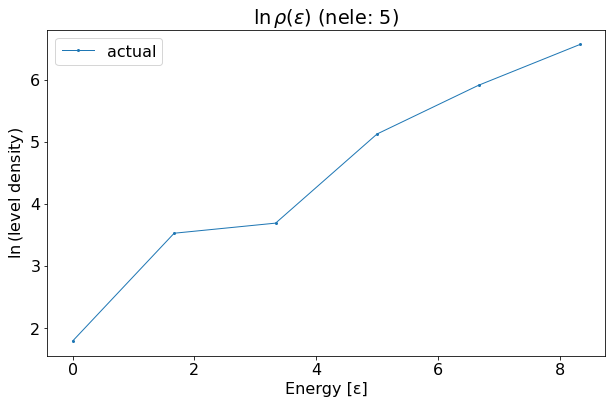

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], np.log(hist), marker=".", linewidth=1, ms=4, label="actual")
plt.legend()
plt.xlabel("Energy [ε]")
plt.ylabel(r"$\ln$(level density)")
plt.title(r"$\ln{\rho(\epsilon)}$" + f" (nele: {e_num})")
plt.show()

In [94]:
head_idx = 3
a, b = solve_normal_equation(xs=bins[head_idx:-1], ys=np.log(hist[head_idx:])) # y = a + bx
rho_0 = np.exp(a)
eps_0 = 1/b
# approx_level_density = calc_approx_level_density(states=states12, rho_0=rho_0, eps_0=eps_0)
print(f"rho_0 = {rho_0}\neps_0 = {eps_0}")

rho_0 = 19.750299344944363
eps_0 = 2.312725346751794


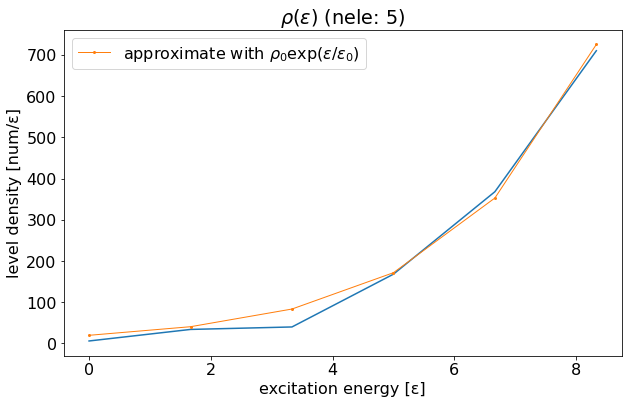

In [95]:
e_num = 5
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], hist)
plt.plot(bins[:-1], rho_0 * np.exp(bins[:-1]/eps_0), marker=".", linewidth=1, ms=4, label=r"approximate with $\rho_0\exp(\epsilon/\epsilon_0)$")
plt.legend()
plt.xlabel("excitation energy [ε]")
plt.ylabel("level density [num/ε]")
plt.title(fr"$\rho(\epsilon)$ (nele: {e_num})")
plt.show()

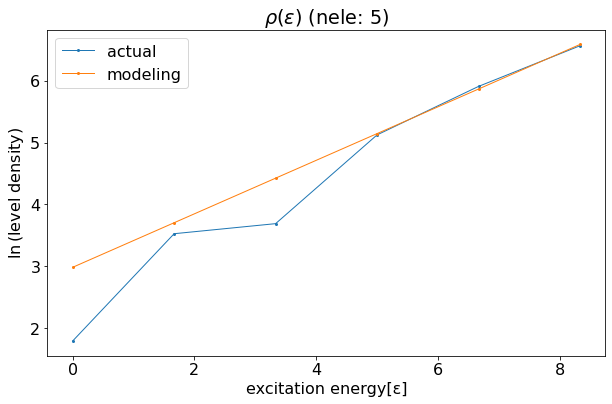

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], np.log(hist), marker=".", linewidth=1, ms=4, label="actual")
plt.plot(bins[:-1], a + b * bins[:-1], marker=".", linewidth=1, ms=4, label="modeling")
plt.legend()
plt.xlabel("excitation energy[ε]")
plt.ylabel(r"$\ln$(level density)")
plt.title(fr"$\rho(\epsilon)$ (nele: {e_num})")
plt.show()

In [98]:
eV2eps = eps_0 / 150
ne = 1e+16 #[m^-3]
Te = 30 #[eV]
fermi = SpinFermi(states=states5, Te=Te, ne=ne, eV2eps=eV2eps, scaled_S_0=0.01, loop_assure=False, loop_lim=100000, threshold=0.1)

In [99]:
scores_per_state, population = fermi.calc_population()

loop: 17914, diff: 0.099609375, eigen: 17588398544546.352


In [100]:
population[:10]

array([4.99999996e-01, 4.99999996e-01, 1.45747011e-09, 1.45747011e-09,
       1.68262307e-09, 1.68262307e-09, 7.93422443e-11, 7.93422443e-11,
       8.13288131e-11, 8.13288131e-11])

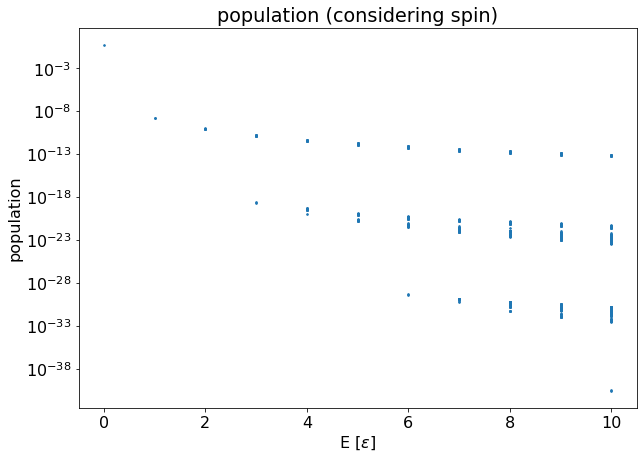

In [110]:
loop_num = 17914
plt.figure(figsize=(10, 7))
# plt.title(f"th: 0.1 ({loop_num} loop, eigen = 17588398544546.352)")
plt.title("population (considering spin)")
plt.scatter(scores_per_state - scores_per_state[0], population, s=2, alpha=0.8)
plt.yscale("log")
# plt.ylim(bottom=1e-33)
plt.xlabel(r"E [$\epsilon$]")
plt.ylabel("population")
plt.show()

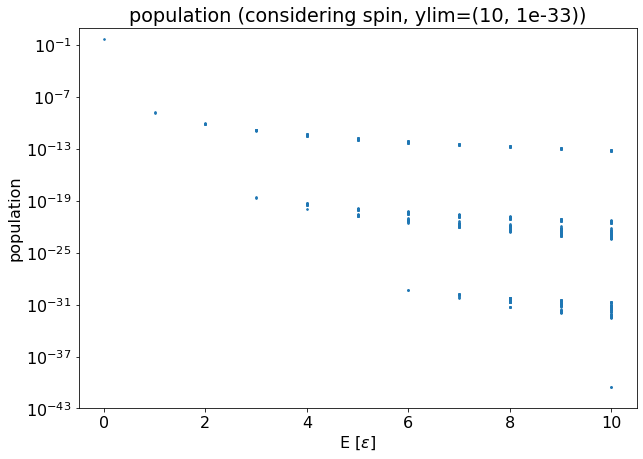

In [113]:
loop_num = 17914
plt.figure(figsize=(10, 7))
# plt.title(f"th: 0.1 ({loop_num} loop, eigen = 17588398544546.352)")
plt.title("population (considering spin, ylim=(10, 1e-33))")
plt.scatter(scores_per_state - scores_per_state[0], population, s=2, alpha=0.8)
plt.yscale("log")
plt.ylim(top=10, bottom=1e-43)
plt.xlabel(r"E [$\epsilon$]")
plt.ylabel("population")
plt.show()

In [20]:
eV2eps = eps_0 / 150
ne = 1e+16 #[m^-3]
Te = 30 #[eV]
fermi = SpinFermi(states=states5, Te=Te, ne=ne, eV2eps=eV2eps, scaled_S_0=0.01, loop_assure=False, loop_lim=10000000, threshold=0.1)
scores_per_state, population = fermi.calc_population()

loop: 69335, diff: 0.099609375


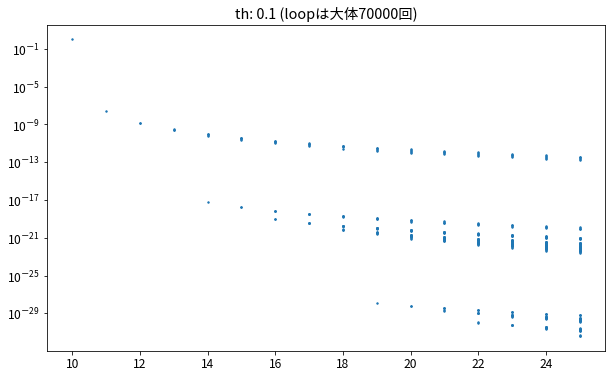

In [22]:
plt.figure(figsize=(10, 6))
plt.title("th: 0.1 (loopは大体70000回)")
plt.scatter(scores_per_state, population, s=2)
plt.yscale("log")
plt.show()

In [18]:
eV2eps = eps_0 / 150
ne = 1e+23 #[m^-3]
Te = 100 #[eV]
fermi = SpinFermi(states=states5, Te=Te, ne=ne, eV2eps=eV2eps, scaled_S_0=0.01, loop_assure=False, loop_lim=10000000, threshold=0.001)
scores_per_state, population = fermi.calc_population()

KeyboardInterrupt: 

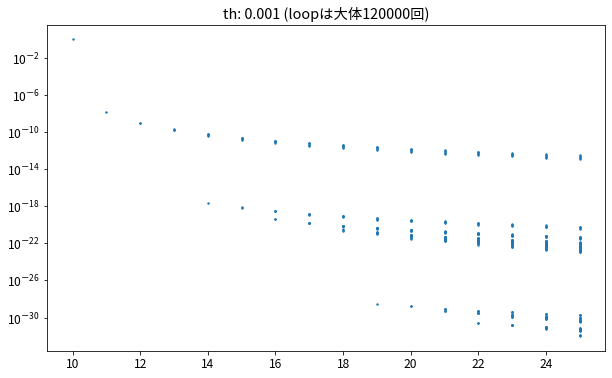

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("th: 0.001 (loopは大体120000回)")
plt.scatter(scores_per_state, population, s=2)
plt.yscale("log")
plt.show()

# 全状態間遷移可能

In [20]:
fermi_all = SpinFermi(states=states5, Te=Te, ne=ne, eV2eps=eV2eps, scaled_S_0=0.01, loop_assure=False, threshold=0.001, loop_lim=1000000, one_particle_transit=False)

In [21]:
scores_per_state_all, population_all = fermi_all.calc_population()

loop: 1000000, diff: 0.0390625


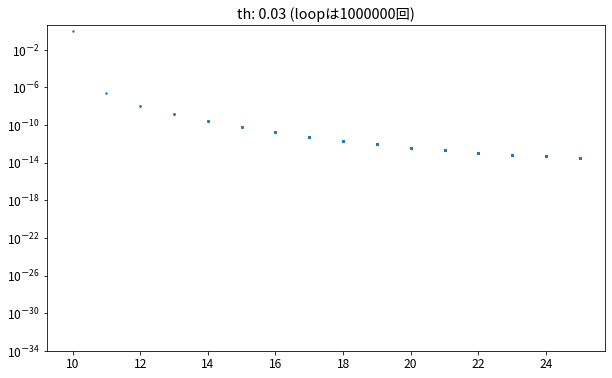

In [23]:
plt.figure(figsize=(10, 6))
plt.title("th: 0.03 (loopは1000000回)")
plt.scatter(scores_per_state_all, population_all, s=2)
plt.yscale("log")
plt.ylim(1e-34, )
plt.show()

In [24]:
fermi_all_01 = SpinFermi(states=states5, Te=Te, ne=ne, eV2eps=eV2eps, scaled_S_0=0.01, loop_assure=False, threshold=0.1, loop_lim=1000000, one_particle_transit=False)

In [25]:
scores_per_state_all_01, population_all_01 = fermi_all_01.calc_population()

loop: 467762, diff: 0.09765625


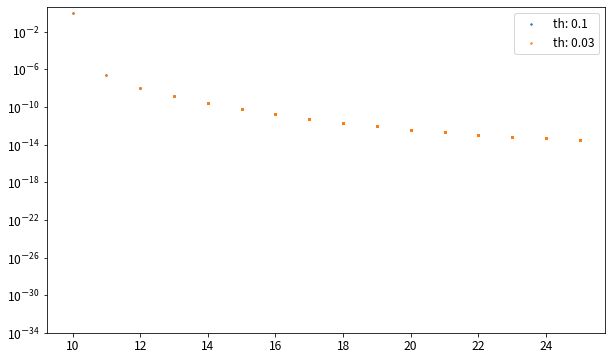

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(scores_per_state_all_01, population_all_01, s=2, label="th: 0.1")
plt.scatter(scores_per_state_all, population_all, s=2, label="th: 0.03")
plt.legend()
plt.yscale("log")
plt.ylim(1e-34, )
plt.show()